In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import random

In [2]:
class IterativeBase():
    def __init__(self, symbol, start, end, amount, use_spread = True):
        self.symbol=symbol
        self.start=start
        self.end=end
        self.initial_balance = amount
        self.current_balance = amount
        self.esunits = 0
        self.estrades = 0
        self.nqunits = 0
        self.nqtrades = 0
        self.ymunits = 0
        self.ymtrades = 0
        self.rtytrades = 0
        self.rtyunits = 0
        self.nqposition = 0
        self.ymposition = 0
        self.esposition = 0
        self.rtyposition = 0
        self.nq=1
        self.cumnav = []
        self.cumnavdf = []
        self.xmethod = []
        self.use_spread=use_spread
        self.firstfive = 0
        self.simdf = pd.DataFrame()
        self.get_data()
        
    def get_data(self):
        test= pd.read_csv("5mindataESYMNQ", parse_dates=[0], index_col=0).dropna()
#         test.index = pd.to_datetime(test.index, utc=True)
#         test = test.tz_convert('US/Eastern')
        test= test.loc[self.start:self.end]
        self.data = test
        
    def plot_data(self, cols = None):
        if cols is None:
            cols="ESClose"
        self.data[cols].plot(figsize = (12,8))
        
    def get_values(self, bar):
        date= str(self.data.index[bar])
        esclose= self.data["ESClose"].iloc[bar]
        nqclose= self.data["NQClose"].iloc[bar]
        ymclose= self.data["YMClose"].iloc[bar]
        rtyclose= self.data["RTYClose"].iloc[bar]
        return date, esclose, nqclose, ymclose, rtyclose
    
    
    def print_current_balance(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        print("{}| Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_es(self, bar, esunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            esclose+= esclose*.0000652
        if amount is not None:
            esunits = int(amount / esclose)
        self.current_balance -= esunits * esclose
        self.esunits += esunits
        self.estrades += 1
        print("{}| Bot {} ES @ {}".format(date, esunits, esclose))
    
    def sell_es(self, bar, esunits = None, amount=None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            esclose-= esclose*.0000652
        if amount is not None:
            esunits = int(amount / esclose)
        self.current_balance += esunits * esclose
        self.esunits -= esunits
        self.estrades += 1
        print("{}| Sold {} ES @ {}".format(date, esunits, esclose))  
        
    def buy_nq(self, bar, nqunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            nqclose+= nqclose*.0000093
        if amount is not None:
            nqunits = int(amount / nqclose)
        self.current_balance -= nqunits * nqclose
        self.nqunits += nqunits
        self.nqtrades += 1
        print("{}| Bot {} NQ @ {}".format(date, nqunits, nqclose))
        
    def sell_nq(self, bar, nqunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            nqclose-= nqclose*.0000093 # ROUNDTRIP COMMISSION ONLY. ASSUMES lIMITS ORDERS. MARKET ORDERS ON YM
        if amount is not None:
            nqunits = int(amount / nqclose)
        self.current_balance += nqunits * nqclose
        self.nqunits -= nqunits
        self.nqtrades += 1
        print("{}| Sold {} NQ @ {}".format(date, nqunits, nqclose))
        
    def buy_ym(self, bar, ymunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            ymclose+= ymclose*.00012 #.00019 assumes 6 pt spread. ROUNDTRIP COMMISSION + FULL SPREAD.
        if amount is not None:
            ymunits = int(amount / ymclose)
        self.current_balance -= ymunits * ymclose
        self.ymunits += ymunits
        self.ymtrades += 1
        print("{}| Bot {} YM @ {}".format(date, ymunits, ymclose))
    
    def sell_ym(self, bar, ymunits = None, amount = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        if self.use_spread:
            ymclose-= ymclose*.00012       
        if amount is not None:
            ymunits = int(amount / ymclose)
        self.current_balance += ymunits * ymclose
        self.ymunits -= ymunits
        self.ymtrades += 1
        print("{}| Sold {} YM @ {}".format(date, ymunits, ymclose))
    
    def buy_rty(self, bar, rtyunits = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance -= rtyunits * rtyclose
        self.rtyunits += rtyunits
        self.rtytrades += 1
        print("{}| Bot ES @ {}".format(date, rtyclose))
    
    def sell_rty(self, bar, rtyunits = None):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance += rtyunits * rtyclose
        self.rtyunits -= rtyunits
        self.rtytrades += 1
        print("{}| Sold RTY @ {}".format(date, rtyclose)) 
        
    def print_current_nav(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        nav = self.current_balance + (self.esunits * esclose)+ (self.rtyunits * rtyclose) + (self.nqunits * nqclose) + (self.ymunits * ymclose)
        self.cumnavdf.append([date, nav, esclose])
        self.cumnav.append(nav)
#         x=np.log(self.cumnav[-1]/self.cumnav[-2])
        print("{} | Net Asset Value = {}".format(date, round(nav,2)))
    
    def close_position(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        self.current_balance += self.esunits * esclose # closing final position (works with short and long!)
        self.current_balance += self.nqunits * nqclose
        self.current_balance += self.ymunits * ymclose
        self.current_balance += self.rtyunits * rtyclose
        self.esunits = 0 # setting position to neutral
        self.nqunits = 0
        self.ymunits = 0
        self.rtyunits = 0
        self.nqtrades += 1
        self.estrades += 1
        #self.ymtrades += 1
        #self.rtytrades += 1   
    def method(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        units=self.nqunits
        self.xmethod.append(units)
    
    def stats(self,bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        simdf = pd.DataFrame(self.cumnavdf, columns=['Datetime', 'nav', 'NQ'])
        simdf['Datetime'] = pd.to_datetime(simdf['Datetime'])   
        simdf.set_index('Datetime',inplace=True)
        simdf["NQlogreturn"]=np.log(simdf["NQ"] / simdf["NQ"].shift(1))
        simdf["logret"]=np.log(simdf.nav/simdf.nav.shift(1))
        simdf["cumlogret"]=np.cumsum(simdf.logret).apply(np.exp)
        simdf["nqcumlogret"]=np.cumsum(simdf.NQlogreturn).apply(np.exp)
        simdf["cummax"]=simdf.cumlogret.cummax()
        simdf["drawdown"]=-(simdf["cumlogret"]-simdf["cummax"])/simdf["cummax"]
        logret=simdf["logret"]
        simdf["simpreturn"]=simdf.nav/simdf.nav.shift(1)-1
        self.simdf=simdf
        logretdown=np.where(logret<0,logret,0)
        downside_dev=np.sqrt(np.mean(logretdown**2))
        mean=simdf["logret"].mean()
        std=simdf["logret"].std()
        meansimp=simdf["simpreturn"].mean()
        annualmean=mean*252
        sortino=(mean-.00012)/downside_dev*np.sqrt(252)
        maxdrawdown=simdf.drawdown.max()
        skew=logret.skew()
        kurt=logret.kurt()
        years=(self.data.index[-1]-self.data.index[1]).days/365
        cagr=(self.cumnav[-1]/self.initial_balance)**(1/years)-1
        benchmarkcagr=(simdf["NQ"].iloc[-1] / simdf["NQ"].iloc[0])**(1/years)-1
        maxdayloss= simdf["simpreturn"].min()
        dd50=(simdf["drawdown"]>.5).mean()
        dd25=(simdf["drawdown"]>.25).mean()
        var=simdf["simpreturn"].var()
        kelly=meansimp/var
        print("Ave. log Return per trade = {}".format(round(mean, 5)))
        print("Ave. simple Return per trade = {}".format(round(meansimp, 5)))
        print("Std per trade = {}".format(std))
        print("Downside dev per trade = {}".format(downside_dev))
        print("CAGR = {}%".format(round(cagr*100, 1)))
        print("Benchmark CAGR = {}%".format(round(benchmarkcagr*100,1)))
        print("Max Drawdown = {}%".format(round(-maxdrawdown*100, 1)))
        print("Max Daily Loss = {}%".format(round(maxdayloss*100, 1)))
        print("% days down 50% from peak = {}%".format(round(dd50*100, 1)))
        print("% days down 25% from peak = {}%".format(round(dd25*100, 1)))
        print("Sortino = {}".format(round(sortino, 2)))
        print("Skew = {}".format(round(skew, 2)))
        print("Kurtosis = {}".format(round(kurt, 2)))
        print("Kelly Criterion = {}".format(round(kelly, 2)))
        plt.yscale("log") 
        plt.plot(simdf[["cumlogret","nqcumlogret"]])
        #simdf.loc["2007":"2022",["cumlogret","nqcumlogret"]].plot(figsize=[13,10], yscale="log")
        
        
       
    def close_pos(self, bar):
        date, esclose, nqclose, ymclose, rtyclose = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.esunits * esclose # closing final position (works with short and long!)
        self.current_balance += self.nqunits * nqclose
        self.current_balance += self.ymunits * ymclose
        self.current_balance += self.rtyunits * rtyclose
        print("{} | closing position of {} ES for {}".format(date, self.esunits, esclose))
        print("{} | closing position of {} NQ for {}".format(date, self.nqunits, nqclose))
        print("{} | closing position of {} YM for {}".format(date, self.ymunits, ymclose))
        print("{} | closing position of {} RTY for {}".format(date, self.rtyunits, rtyclose))
        self.esunits = 0 # setting position to neutral
        self.nqunits = 0
        self.ymunits = 0
        self.rtyunits = 0
        self.nqtrades += 1
        self.estrades += 1
        self.ymtrades += 1
        self.rtytrades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, ((self.estrades+self.nqtrades+self.ymtrades+self.rtytrades)/2)))
        print("per trade: {}".format((self.current_balance - self.initial_balance) /((self.estrades+self.nqtrades+self.ymtrades+self.rtytrades)/2)))
        self.stats(bar)
        print(75 * "-")

In [ ]:
class Momentum(IterativeBase):
    
    
    def ym_nq_momentum(self, period, dayperiod, entryhr, checkhr, exithr, x, y, lev):
        
        # nice printout
        stm = "Testing Intraday Momentum Strategy , periods:{}, entry:{}, checkhr:{}, exit:{}, leverage:{} ".format(period, entryhr, checkhr, exithr, lev)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.esunits = 0
        self.estrades = 0
        self.nqunits = 0
        self.nqtrades = 0
        self.ymunits = 0
        self.ymtrades = 0
        self.nqposition = 0
        self.ymposition = 0
        self.esposition = 0
        
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.firstfive = 0
        self.bestreturndow = pd.DataFrame()
        self.bestreturnnas = pd.DataFrame()
        self.dummynas=0
        self.dummydow=0
        self.besthourdow=0
        self.besthournas=0

        self.data["NQxperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(period))
        self.data["YMxperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(period))
        
        
        self.data["ESyperiodReturn"]=np.log(self.data["ESClose"]/self.data["ESClose"].shift(dayperiod))
        self.data["NQyperiodReturn"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(dayperiod))
        self.data["YMyperiodReturn"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(dayperiod))
#        
        self.data["NQret"]=np.log(self.data["NQClose"]/self.data["NQClose"].shift(1))
        self.data["YMret"]=np.log(self.data["YMClose"]/self.data["YMClose"].shift(1))
        self.data["ESret"]=np.log(self.data["ESClose"]/self.data["ESClose"].shift(1))
        self.data["NQVol"]=self.data.NQret.rolling(2000).std()
        self.data["YMvol"]=self.data.YMret.rolling(2000).std()
        self.data["ESvol"]=self.data.ESret.rolling(2000).std()
        self.data["YMmultiplier"]=self.data.NQVol/self.data.YMvol 
        self.data["ESmultiplier"]=self.data.NQVol/self.data.ESvol 
#     
        
        #add hour
        self.data["hour"]=self.data.index.hour
        self.data['day'] = self.data.index.weekday
        self.data["month"]=self.data.index.month
        self.data.dropna(inplace=True)
        
        for bar in range(len(self.data)-1):
        #Saves net asset value into self.cumnavdf once per day    
            if self.data["hour"].iloc[bar]==23 and self.data["hour"].iloc[bar-1]!=23:
                self.print_current_nav(bar)
           
        #Closes open positions during "exithr"          
            if self.nqposition!=0:   
                if self.data["hour"].iloc[bar]==exithr and self.data["hour"].iloc[bar-5]==exithr and self.data["hour"].iloc[bar-6]!=exithr:
                        self.close_position(bar)
                        self.nqposition=0
                        self.ymposition=0
                        self.esposition=0
                         
              
        #Checks which contract has outperformed the other since yesterday's close, volatility adjusted. If one contract
        #has outperformed the other by "x" in the last "period" 5-min periods, that contract is bought and the other sold in a corresponding quantity, volatility adjusted.
            if self.data["hour"].iloc[bar]==entryhr and self.data["hour"].iloc[bar-6]==entryhr:
            
                    if self.nqposition==0:#      
                        
                            if self.data["NQxperiodReturn"].iloc[bar]-(self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])>x:          
                                        cb=self.current_balance
                                        self.sell_ym(bar, amount=cb*lev*self.data["YMmultiplier"].iloc[bar])
                                        self.ymposition=-1
                                        self.buy_nq(bar, amount=cb*lev)
                                        self.nqposition=1
                                        self.nq=1
                                         
                            elif (self.data["YMxperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQxperiodReturn"].iloc[bar]>x:
                              
                                        cb=self.current_balance
        
                                        self.buy_ym(bar, amount=cb*lev*self.data["YMmultiplier"].iloc[bar])
                                        self.ymposition=1
                                        self.sell_nq(bar, amount=cb*lev)
                                        self.nqposition=-1
                                        self.nq=-1
#       #Stop loss check at "checkhr"                             
            elif self.data["hour"].iloc[bar]==checkhr and self.data["hour"].iloc[bar-4]==checkhr:# and self.data["hour"].iloc[bar-7]!=checkhr:
                if self.nqposition==1:
                    if self.data["NQyperiodReturn"].iloc[bar]-(self.data["YMyperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])<y:# and self.data["NQxperiodReturn"].iloc[bar]-self.data["YMxperiodReturn"].iloc[bar]<z:
                                self.close_position(bar)
                                self.nqposition=0
                                self.ymposition=0
                                self.esposition=0
                                 
                                print("stopped")
                         
                elif self.ymposition==1:
                    if (self.data["YMyperiodReturn"].iloc[bar]*self.data["YMmultiplier"].iloc[bar])-self.data["NQyperiodReturn"].iloc[bar]<y:# and self.data["YMxperiodReturn"].iloc[bar]-self.data["NQxperiodReturn"].iloc[bar]<z:
                            self.close_position(bar)
                            self.nqposition=0
                            self.ymposition=0
                            self.esposition=0

                            print("stopped")
         
                
        self.close_pos(bar+1)
        return self.data

In [25]:
trade=Momentum("all3", "2018-01-04", "2020-01-03", 100000, use_spread=True)

---------------------------------------------------------------------------
Testing Intraday Momentum Strategy , periods:180, entry:9, checkhr:11, exit:9, leverage:4 
---------------------------------------------------------------------------
2018-01-15 09:30:00| Bot 19 YM @ 25143.0168
2018-01-15 09:30:00| Sold 57 NQ @ 6911.9357184
2018-01-15 23:00:00 | Net Asset Value = 99516.27
2018-01-16 09:30:00| Sold 19 YM @ 25185.97732
2018-01-16 09:30:00| Bot 56 NQ @ 6961.0647373
2018-01-16 23:00:00 | Net Asset Value = 97823.21
2018-01-17 09:30:00| Bot 19 YM @ 25087.01008
2018-01-17 09:30:00| Sold 56 NQ @ 6902.185809075
2018-01-17 23:00:00 | Net Asset Value = 98816.42
2018-01-18 23:00:00 | Net Asset Value = 99113.42
2018-01-19 09:35:00| Sold 18 YM @ 25198.97576
2018-01-19 09:35:00| Bot 56 NQ @ 6989.56500235
2018-01-21 23:00:00 | Net Asset Value = 98061.35
2018-01-22 23:00:00 | Net Asset Value = 98781.35
2018-01-23 09:35:00| Sold 16 YM @ 25369.95524
2018-01-23 09:35:00| Bot 55 NQ @ 7080.56584865


2018-04-26 23:00:00 | Net Asset Value = 87375.7
2018-04-27 09:30:00| Bot 19 YM @ 23457.8146
2018-04-27 09:30:00| Sold 51 NQ @ 6842.43636475
2018-04-29 23:00:00 | Net Asset Value = 90042.22
2018-04-30 09:30:00| Bot 21 YM @ 23561.82708
2018-04-30 09:30:00| Sold 54 NQ @ 6782.686920425
2018-04-30 23:00:00 | Net Asset Value = 89742.95
2018-05-01 09:30:00| Sold 20 YM @ 23152.2214
2018-05-01 09:30:00| Bot 52 NQ @ 6712.0624216
2018-05-01 23:00:00 | Net Asset Value = 93032.63
2018-05-02 23:00:00 | Net Asset Value = 93137.63
2018-05-03 09:30:00| Sold 21 YM @ 22874.25476
2018-05-03 09:30:00| Bot 55 NQ @ 6712.56242625
2018-05-03 23:00:00 | Net Asset Value = 92269.8
2018-05-04 09:30:00| Sold 21 YM @ 22908.25068
2018-05-04 09:30:00| Bot 55 NQ @ 6735.812642475
stopped
2018-05-06 23:00:00 | Net Asset Value = 91210.12
2018-05-07 23:00:00 | Net Asset Value = 91210.12
2018-05-08 09:50:00| Bot 18 YM @ 23387.8062
2018-05-08 09:50:00| Sold 52 NQ @ 6895.185874175
2018-05-08 23:00:00 | Net Asset Value = 90713

2018-07-30 23:00:00 | Net Asset Value = 119466.39
2018-07-31 09:35:00| Sold 33 YM @ 24518.05748
2018-07-31 09:35:00| Bot 65 NQ @ 7349.56835035
stopped
2018-07-31 23:00:00 | Net Asset Value = 117305.09
2018-08-01 09:40:00| Sold 33 YM @ 24543.05448
2018-08-01 09:40:00| Bot 63 NQ @ 7365.818501475
stopped
2018-08-01 23:00:00 | Net Asset Value = 117403.83
2018-08-02 09:30:00| Sold 32 YM @ 24264.08796
2018-08-02 09:30:00| Bot 64 NQ @ 7329.318162025
2018-08-02 23:00:00 | Net Asset Value = 120874.28
2018-08-03 09:40:00| Bot 33 YM @ 24480.93736
2018-08-03 09:40:00| Sold 64 NQ @ 7465.43057085
2018-08-05 23:00:00 | Net Asset Value = 123381.9
2018-08-06 09:30:00| Sold 32 YM @ 24510.05844
2018-08-06 09:30:00| Bot 65 NQ @ 7488.56964305
2018-08-06 23:00:00 | Net Asset Value = 121453.5
2018-08-07 09:35:00| Bot 30 YM @ 24729.96724
2018-08-07 09:35:00| Sold 63 NQ @ 7566.42963155
2018-08-07 23:00:00 | Net Asset Value = 120979.8
2018-08-08 09:45:00| Sold 30 YM @ 24704.03516
2018-08-08 09:45:00| Bot 63 NQ 

2018-11-13 23:00:00 | Net Asset Value = 143972.14
2018-11-14 09:35:00| Sold 33 YM @ 24539.05496
2018-11-14 09:35:00| Bot 83 NQ @ 6954.814679175
2018-11-14 23:00:00 | Net Asset Value = 147149.33
2018-11-15 09:30:00| Sold 34 YM @ 24078.11028
2018-11-15 09:30:00| Bot 86 NQ @ 6829.813516675
2018-11-15 23:00:00 | Net Asset Value = 146280.12
2018-11-16 09:35:00| Bot 32 YM @ 24277.913
2018-11-16 09:35:00| Sold 84 NQ @ 6868.43612295
2018-11-18 23:00:00 | Net Asset Value = 147824.54
2018-11-19 09:30:00| Bot 33 YM @ 24456.93448
2018-11-19 09:30:00| Sold 87 NQ @ 6886.43595555
2018-11-19 23:00:00 | Net Asset Value = 153461.38
2018-11-20 09:30:00| Sold 35 YM @ 23713.15408
2018-11-20 09:30:00| Bot 94 NQ @ 6577.311168425
2018-11-20 23:00:00 | Net Asset Value = 161735.02
2018-11-21 09:30:00| Sold 39 YM @ 23705.15504
2018-11-21 09:30:00| Bot 98 NQ @ 6688.812205375
2018-11-21 23:00:00 | Net Asset Value = 163542.97
2018-11-22 23:00:00 | Net Asset Value = 164330.97
2018-11-23 09:30:00| Sold 40 YM @ 23450.

2019-02-14 23:00:00 | Net Asset Value = 130277.73
2019-02-15 09:30:00| Bot 25 YM @ 24770.97216
2019-02-15 09:30:00| Sold 72 NQ @ 7097.683990925
2019-02-17 23:00:00 | Net Asset Value = 135184.43
2019-02-18 23:00:00 | Net Asset Value = 135136.43
2019-02-19 23:00:00 | Net Asset Value = 135136.43
2019-02-20 09:50:00| Sold 24 YM @ 25011.9982
2019-02-20 09:50:00| Bot 75 NQ @ 7125.0662625
2019-02-20 23:00:00 | Net Asset Value = 132220.66
2019-02-21 09:55:00| Bot 24 YM @ 24977.997
2019-02-21 09:55:00| Sold 74 NQ @ 7056.184376875
stopped
2019-02-21 23:00:00 | Net Asset Value = 130370.88
2019-02-24 23:00:00 | Net Asset Value = 130370.88
2019-02-25 23:00:00 | Net Asset Value = 130370.88
2019-02-26 09:30:00| Sold 24 YM @ 25085.98932
2019-02-26 09:30:00| Bot 73 NQ @ 7129.56630435
2019-02-26 23:00:00 | Net Asset Value = 130642.03
2019-02-27 23:00:00 | Net Asset Value = 130148.78
2019-02-28 23:00:00 | Net Asset Value = 130148.78
2019-03-01 09:30:00| Bot 23 YM @ 25233.0276
2019-03-01 09:30:00| Sold 72

2019-06-10 23:00:00 | Net Asset Value = 144875.2
2019-06-11 09:50:00| Sold 30 YM @ 25263.96796
2019-06-11 09:50:00| Bot 76 NQ @ 7580.320496325
2019-06-11 23:00:00 | Net Asset Value = 144868.64
2019-06-12 09:30:00| Bot 31 YM @ 25117.01368
2019-06-12 09:30:00| Sold 76 NQ @ 7490.180340675
2019-06-12 23:00:00 | Net Asset Value = 144024.92
2019-06-13 09:50:00| Sold 31 YM @ 25187.97708
2019-06-13 09:50:00| Bot 76 NQ @ 7534.820073175
2019-06-13 23:00:00 | Net Asset Value = 141902.88
2019-06-16 23:00:00 | Net Asset Value = 140896.88
2019-06-17 09:30:00| Sold 29 YM @ 25174.97864
2019-06-17 09:30:00| Bot 75 NQ @ 7513.56987555
2019-06-17 23:00:00 | Net Asset Value = 142209.02
2019-06-18 23:00:00 | Net Asset Value = 143680.52
2019-06-19 09:30:00| Bot 30 YM @ 25604.07212
2019-06-19 09:30:00| Sold 75 NQ @ 7649.928855
2019-06-19 23:00:00 | Net Asset Value = 139668.02
2019-06-20 23:00:00 | Net Asset Value = 140916.77
2019-06-21 09:35:00| Bot 28 YM @ 25844.10092
2019-06-21 09:35:00| Sold 72 NQ @ 7725.9

2019-09-23 23:00:00 | Net Asset Value = 158391.53
2019-09-24 23:00:00 | Net Asset Value = 158391.53
2019-09-25 09:30:00| Bot 32 YM @ 25979.11712
2019-09-25 09:30:00| Sold 82 NQ @ 7692.9284551
2019-09-25 23:00:00 | Net Asset Value = 153804.92
2019-09-26 09:30:00| Bot 32 YM @ 26038.1242
2019-09-26 09:30:00| Sold 80 NQ @ 7747.677945925
2019-09-26 23:00:00 | Net Asset Value = 153937.18
2019-09-27 09:35:00| Bot 32 YM @ 26028.123
2019-09-27 09:35:00| Sold 79 NQ @ 7746.42795755
2019-09-29 23:00:00 | Net Asset Value = 156151.3
2019-09-30 23:00:00 | Net Asset Value = 155626.8
2019-10-01 09:30:00| Sold 33 YM @ 26053.87316
2019-10-01 09:30:00| Bot 80 NQ @ 7777.57233075
2019-10-01 23:00:00 | Net Asset Value = 159555.83
2019-10-02 09:35:00| Sold 34 YM @ 25345.95812
2019-10-02 09:35:00| Bot 85 NQ @ 7569.0703917
2019-10-02 23:00:00 | Net Asset Value = 164455.67
2019-10-03 09:30:00| Sold 35 YM @ 25127.98428
2019-10-03 09:30:00| Bot 88 NQ @ 7538.320105725
2019-10-03 23:00:00 | Net Asset Value = 168362.

,NQClose,YMClose,ESClose,RTYClose,NQxperiodReturn,YMxperiodReturn,ESyperiodReturn,NQyperiodReturn,YMyperiodReturn,NQret,YMret,ESret,NQVol,YMvol,ESvol,YMmultiplier,ESmultiplier,hour,day,month
0,,,,,,,,,,,,,,,,,,,,
2018-01-15 07:25:00,6912.75,25117.0,2748.75,2748.75,0.003042,0.008155,0.003097,0.002462,0.007232,0.000289,0.000159,0.000182,0.000328,0.000265,0.000249,1.239996,1.317588,7,0,1
2018-01-15 07:30:00,6910.25,25111.0,2748.00,2748.00,0.002354,0.007796,0.002733,0.001847,0.007074,-0.000362,-0.000239,-0.000273,0.000328,0.000265,0.000249,1.240110,1.317569,7,0,1
2018-01-15 07:35:00,6910.25,25115.0,2748.75,2748.75,0.001847,0.007554,0.002732,0.001593,0.007073,0.000000,0.000159,0.000273,0.000328,0.000265,0.000249,1.240078,1.316918,7,0,1
2018-01-15 07:40:00,6911.25,25123.0,2749.00,2749.00,0.002209,0.007993,0.002823,0.001774,0.007431,0.000145,0.000318,0.000091,0.000328,0.000265,0.000249,1.239799,1.316912,7,0,1
2018-01-15 07:45:00,6912.50,25122.0,2749.50,2749.50,0.001991,0.007111,0.003005,0.002209,0.007391,0.000181,-0.000040,0.000182,0.000328,0.000265,0.000249,1.240011,1.316875,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03 16:35:00,8741.25,27690.0,3159.25,3159.25,-0.000772,-0.001227,-0.000712,-0.002485,-0.002489,0.000057,-0.000036,0.000079,0.000387,0.000312,0.000309,1.240618,1.252276,16,4,1
2020-01-03 16:40:00,8740.75,27684.0,3158.75,3158.75,-0.000743,-0.001408,-0.000791,-0.002685,-0.002742,-0.000057,-0.000217,-0.000158,0.000387,0.000312,0.000309,1.240430,1.252140,16,4,1
2020-01-03 16:45:00,8742.75,27689.0,3159.25,3159.25,-0.000715,-0.001371,-0.000396,-0.001943,-0.002237,0.000229,0.000181,0.000158,0.000387,0.000312,0.000309,1.240449,1.252157,16,4,1


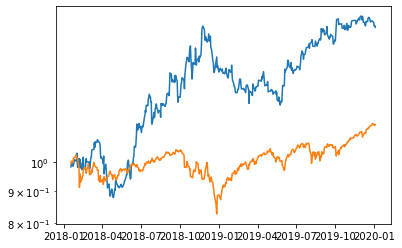

In [26]:
trade.ym_nq_momentum(180, 198, 9, 11,9,.002, 0, 4) # period, dayperiod, entryhr, checkhr, exithr, x, y, lev)